# Multi-Dimensional Linear Regression

The [dataset](https://github.com/ageron/handson-ml/tree/master/datasets/housing) used for this excercise in Multi-Dimensional Linear Regression is a modified version of the California Housing dataset available from [Luís Torgo's page](http://www.dcc.fc.up.pt/%7Eltorgo/Regression/cal_housing.html) (University of Porto). Luís Torgo obtained it from the StatLib repository (which is closed now). The dataset may also be downloaded from StatLib mirrors.

This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

## Theoretical background 

- [Generalized Linear Models](http://scikit-learn.org/stable/modules/linear_model.html)
- [Linear Regression Example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html) 
--- 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
sns.set()

In [2]:
data = pd.read_csv("housing.csv", na_values='') 

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Missing values

According to [the README.md provided with the dataset](https://github.com/ageron/handson-ml/blob/master/datasets/housing/README.md) 

> The dataset in this directory is almost identical to the original, with two differences:
> - 207 values were randomly removed from the total_bedrooms column, so we can discuss what to do with missing data. [...]

We have decided to try to produce approximate values for the missing values by interpolating variables with a high correlation. ```total_bedrooms``` correlates highly with ```households``` (0.98) and ```total_rooms``` (0.93). 

In [5]:
missing_values = data[data.isnull().any(axis=1)]

In [6]:
missing_values.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY


In [7]:
# drops rows if any NA values are present (i.e values are missing)
data_valid_values = data.dropna(axis=0,how='any')

In [8]:
data_valid_values.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Splitting dataset into training and testing subsets 

In [9]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [10]:
# Split the dataset pseudo-randomly into training and testing subsets 

"""
for details see http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
"""

x = np.array(data_valid_values['households'], dtype=pd.Series).reshape(-1, 1) # existing values for households 
y = data_valid_values['total_bedrooms'].values # existing values for total_bedrooms 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=42)

results = regr.fit(x_train, y_train)
results

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# Make predictions using the training dataset
y_prediction = regr.predict(x_test)

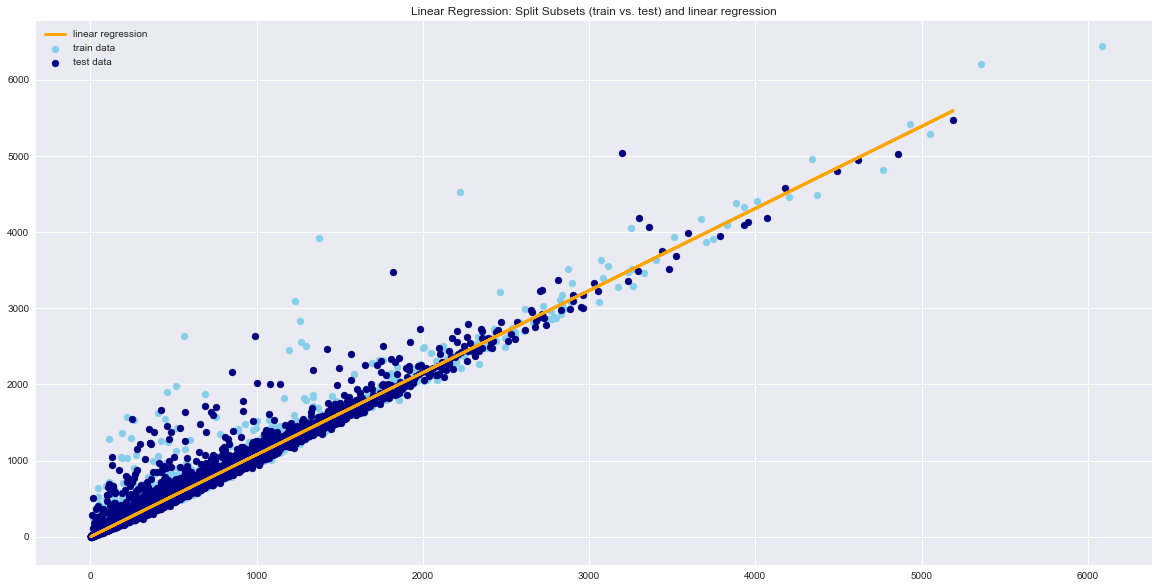

In [12]:
# Plot subsets and prediction 
plt.figure(figsize=(20,10))
plt.scatter(x_train, y_train, color='skyblue', label='train data')
plt.scatter(x_test, y_test, color='navy', label='test data')
plt.plot(x_test, y_prediction, color='orange', linewidth=3, label='linear regression')

# plt.xscale('log')
# plt.yscale('log')

plt.axis('tight')
plt.legend()
plt.title("Linear Regression: Split Subsets (train vs. test) and linear regression")

plt.show();

In [13]:
# The coefficients
print("Coefficient: %.10f"
      % regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_prediction))

Coefficient: 1.0782483484
Mean squared error: 6657.04
Variance score: 0.96


In [14]:
x_missing_values = np.array(missing_values['households'], dtype=pd.Series).reshape(-1, 1) # existing values for households 

# Make estimates of missing values using the training dataset
y_missing_values = regr.predict(x_missing_values)

In [15]:
y_missing_values.shape

(207,)

In [16]:
missing_values['total_bedrooms_estimate'] = pd.DataFrame(y_missing_values)

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
missing_values.loc[:,10] = y_missing_values

/home/user/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/user/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
missing_values.loc[:,4].shape

KeyError: 'the label [4] is not in the [columns]'

In [ ]:
y_missing_values.shape

In [ ]:
# Train the model using existing values 

x_valid_values = np.array(data_valid_values['households'], dtype=pd.Series).reshape(-1, 1) # households
y_valid_values = data_valid_values['total_bedrooms'].values # total_bedrooms
x_missing_values = np.array(missing_values['households'], dtype=pd.Series).reshape(-1, 1) # households
y_missing_values = data_valid_values['total_bedrooms'].values # total_bedrooms

regr.fit(x_train, y_train)

In [ ]:
# Make prediction using the existing values 

y_missing_values = regr.predict(x_missing_values)

In [ ]:
# The coefficients
print("Coefficient: %.10f"
      % regr.coef_)

In [ ]:
# Plot outputs
plt.figure(figsize=(20,10))
plt.scatter(x_valid_values, y_valid_values, color='skyblue', label='train data')
plt.scatter(x_missing_values, y_missing_values, color='navy', label='test data')
plt.plot(x_valid_values, y_missing_values, color='orange', linewidth=3, label='linear regression')

plt.axis('tight')
plt.legend()
plt.title("Linear Regression: households vs. total_bedrooms")

plt.show();

## Descriptive distribution analysis

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(data['longitude'], data['latitude'], c=data['median_house_value'], cmap="hot", label='longitude (x) vs. latitude (y)')
plt.show();

In [ ]:
data.hist(bins=100, density=True, figsize=(20,20))
plt.show();

In [ ]:
corr_matrix = data.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 16}, linewidths=1, cmap='viridis');

--- 
## Normalization

In [ ]:
data_norm = data.copy()

In [ ]:
# drops rows if any NA values are present (i.e values are missing)
data_norm = data_norm.dropna(axis=0,how='any')

In [ ]:
data_norm.describe()